# Exercise - Logistic Regression

The client bank *XYZ* is running a direct marketing (phone calls) campaign. The classification goal is to predict if the client will subscribe a term deposit or not.

The data is obtained from [UCI Machine Learning repository]( http://mlr.cs.umass.edu/ml/datasets/Bank+Marketing)

### Attribute Information:

#### bank client data:
- **age**: (numeric)
- **job** : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- **marital** : marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)
- **education** (categorical: 'basic.4y', 'basic.6y', 'basic.9y','high.school', 'illiterate' ,'professional.course', 'university.degree', 'unknown')
- **default**: has credit in default? (categorical: 'no','yes','unknown')
- **housing: has housing loan? (categorical: 'no','yes','unknown')
- **loan**: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:
- **contact**: contact communication type (categorical: 'cellular', 'telephone')
- **month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- **day**: last contact day of the month (numerical: 1, 2, 3, 4, ...)
- **duration**: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:
- **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- **previous**: number of contacts performed before this campaign and for this client (numeric)
- **poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### Output variable (desired target):
- **deposit** - has the client subscribed a term deposit? (binary: 'yes','no')



In [ ]:
#1. import libraries
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as m
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


C:\Users\Akhilesh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
#2. import data
data = pd.read_csv("bank.csv")


In [ ]:
#3. Display first few records
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
#4. check column names
data.columns.values


array(['age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration',
       'campaign', 'pdays', 'previous', 'poutcome', 'deposit'], dtype=object)

In [ ]:
#5. do label encoding
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)
new = MultiColumnLabelEncoder(columns = ['job','marital',
                                         'education','default',
                                         'housing','loan',
                                         'contact','month',
                                         'poutcome']).fit_transform(data)


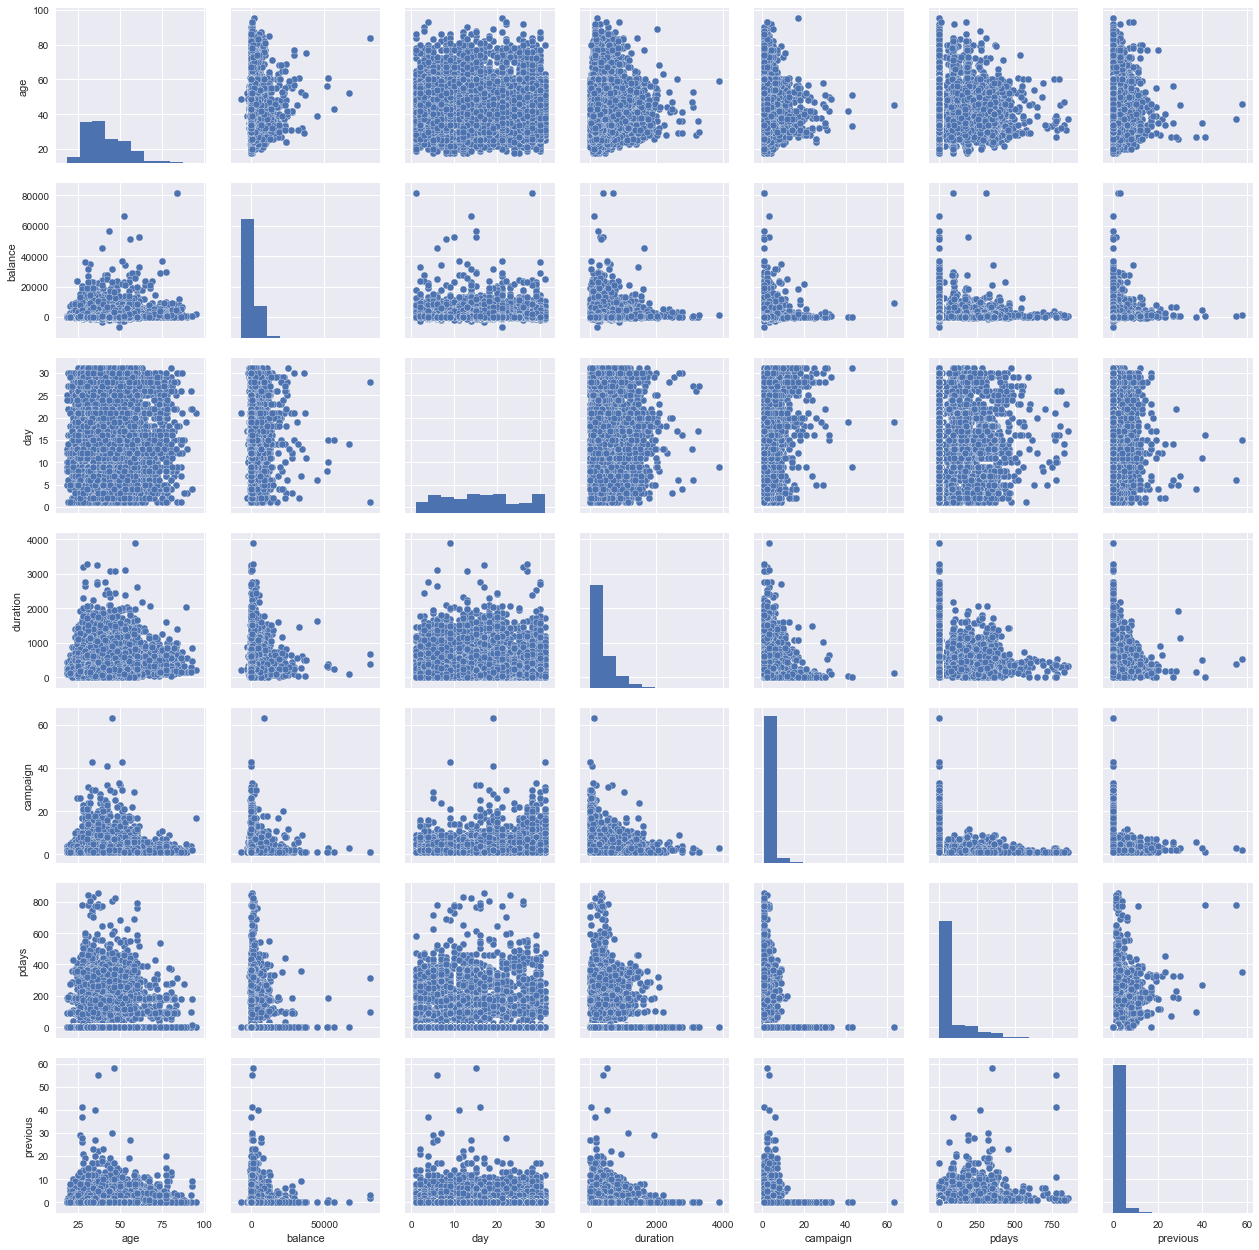

In [ ]:
#6. do some exploratory data analysis
sns.pairplot(data)

In [ ]:
data.corr()

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.112300,-0.000762,0.000189,-0.005278,0.002774,0.020169
balance,0.112300,1.000000,0.010467,0.022436,-0.013894,0.017411,0.030805
day,-0.000762,0.010467,1.000000,-0.018511,0.137007,-0.077232,-0.058981
duration,0.000189,0.022436,-0.018511,1.000000,-0.041557,-0.027392,-0.026716
campaign,-0.005278,-0.013894,0.137007,-0.041557,1.000000,-0.102726,-0.049699
pdays,0.002774,0.017411,-0.077232,-0.027392,-0.102726,1.000000,0.507272
previous,0.020169,0.030805,-0.058981,-0.026716,-0.049699,0.507272,1.000000


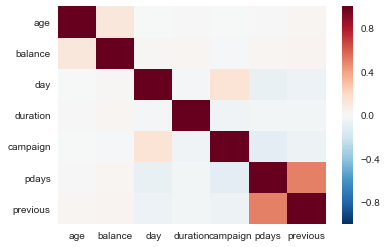

In [ ]:
sns.heatmap(data.corr())


In [ ]:
#7. Build logistic regression model


X = new.iloc[:, :-1].values
y = new.iloc[:, 16].values


In [ ]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\Akhilesh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[974, 231],
       [238, 790]])

In [ ]:
#8. Build L2 logistic regression model
new1 = MultiColumnLabelEncoder(columns = ['job','marital',
                                         'education','default',
                                         'housing','loan',
                                         'contact','month',
                                         'poutcome','deposit']).fit_transform(data)


In [ ]:
X_1 = new1.iloc[:, :-1].values
y_1 = new1.iloc[:, 16].values

In [ ]:
from sklearn.cross_validation import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size = 0.25, random_state = 0)


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_1 = sc.fit_transform(X_train_1)
X_test_1 = sc.transform(X_test_1)

In [ ]:
from sklearn.linear_model import Ridge
ridgeReg = Ridge(alpha = 0.05, normalize = True)
ridgeReg.fit(X_train_1,y_train_1)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [ ]:
y_pred_1 = ridgeReg.predict(X_test_1)

In [ ]:
mse = np.mean((y_pred_1 - y_test_1)**2)
ridgeReg.score(X_test_1,y_test_1)

0.31486729057918239

In [ ]:
#9. Build L1 logistic regression model
from sklearn.linear_model import Lasso
lassoReg = Lasso(alpha = 0.3, normalize = True)
lassoReg.fit(X_train_1,y_train_1)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
y_pred_2 = lassoReg.predict(X_test_1)

In [ ]:
mse_1 = np.mean((y_pred_2 - y_test_1)**2)
lassoReg.score(X_test_1,y_test_1)

-0.0010923538048550618

In [ ]:
#10. Find generalization error. Use 80/20 split
print("L2-Generalisation error is ",mse)
print("L1-Generalisation error is ",mse_1)

L2-Generalisation error is  0.170266760268
L1-Generalisation error is  0.248787934757


In [ ]:
#11. report mis-classification rate
